### YOLO


The YOLO series of models perform object detection: identifying which part of an image contains an object, and classifying it into one of a number of categories. In this project, we'll get images from the Department of Defense website, and apply object detection to answer the following questions:

- Which image has the most people?
- Which image has the most ties?


In [22]:
import torch
from PIL import Image

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-6 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [23]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
import os
import os.path
import glob

html = requests.get('https://www.dhs.gov/medialibrary').content
soup = BeautifulSoup(html)

# Get the list of image elements
images = soup.select('img') # SOLUTION
# Get the url for each image, if it's a JPEG
urls = [a['src'] for a in images if '.JPG' in a['src'].upper()]
urls

['https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets/audio/thumbs/24_1218_st_podcast_m1e20_putting_the_platform_above_card.jpg.webp?itok=Js0Paf06',
 'https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets/images/Daniel%20White%20-%20DHS%20Portrait.JPG.webp?itok=WWiczRLw',
 'https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets/videos/thumbs/22_0426_CISA_options-for-consideration-active-shooter-training.jpg.webp?itok=N_eSWh4w',
 'https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets-temp/20241122_Lincoln%20County%20DRC-18.jpg.webp?itok=8vXJm2-d',
 'https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets-temp/20241122_Lincoln%20County%20DRC-16.jpg.webp?itok=QhOeSxMM',
 'https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets-temp/20241122_Lincoln%20County%20DRC-14.jpg.webp?itok=vRNmy_7B',
 'https://www.dhs.gov/medialibrary-assets/styles/medium/public/assets-temp/20241122_Lincoln%20County%20DRC-10.jpg.webp?i

In [24]:
out_dir = 'object_detection_images'
if not os.path.exists(out_dir):
  os.mkdir(out_dir)

for url in urls:
  # Download each image to the out_dir directory
  # BEGIN SOLUTION
  urllib.request.urlretrieve(
      url,
      out_dir + '/' + os.path.basename(urllib.parse.urlparse(url).path)
  )
  # END SOLUTION

# Load the images using PIL
images = [
    Image.open(out_dir + '/' + image_path)
    for image_path in os.listdir(out_dir)
]

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


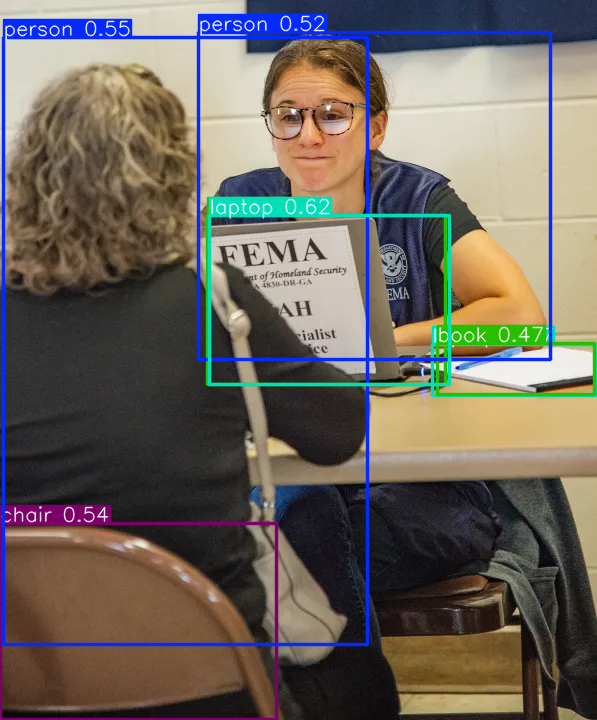

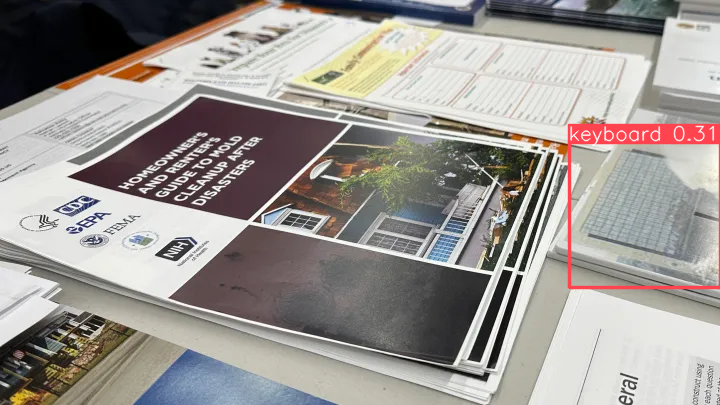

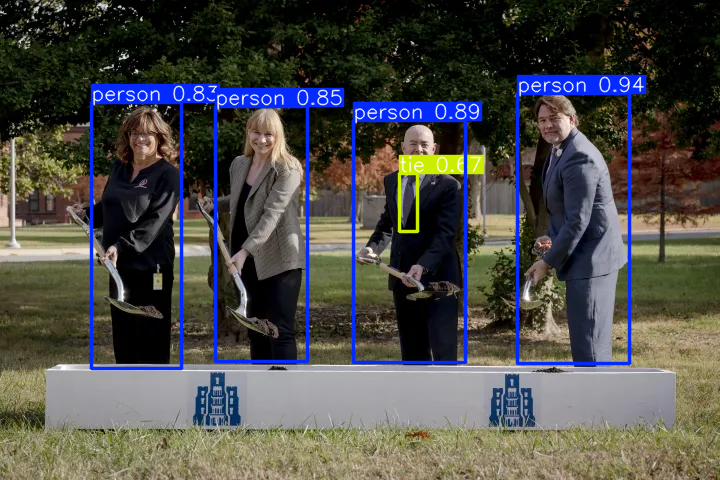

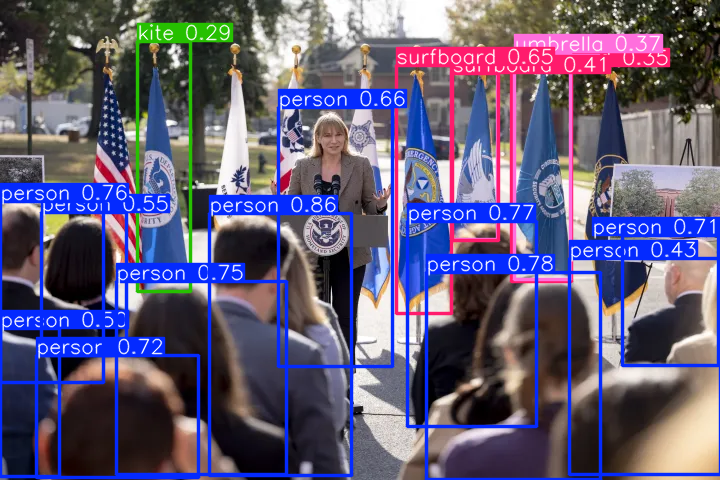

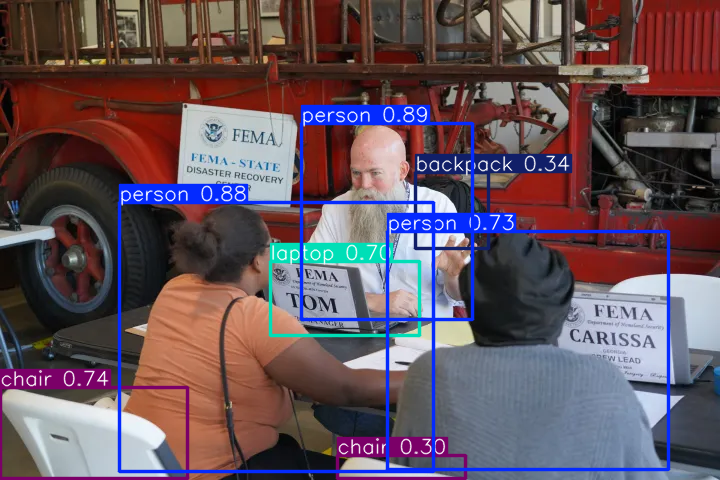

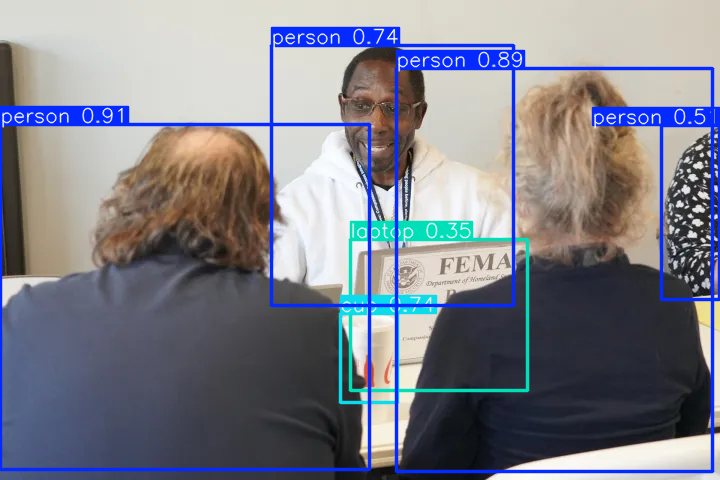

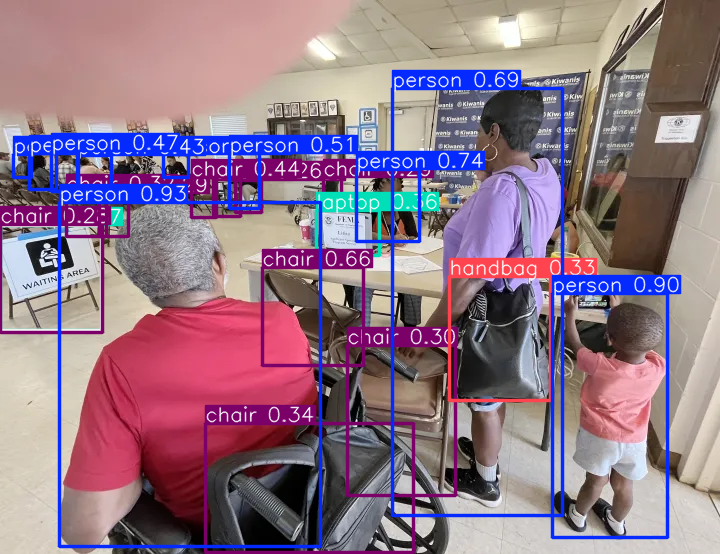

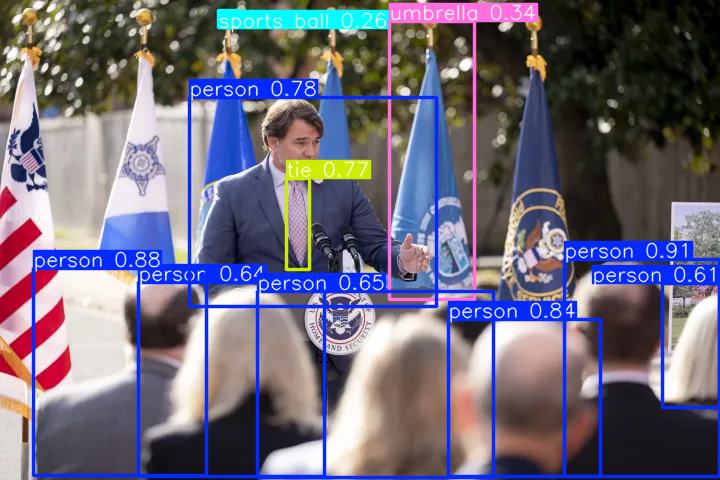

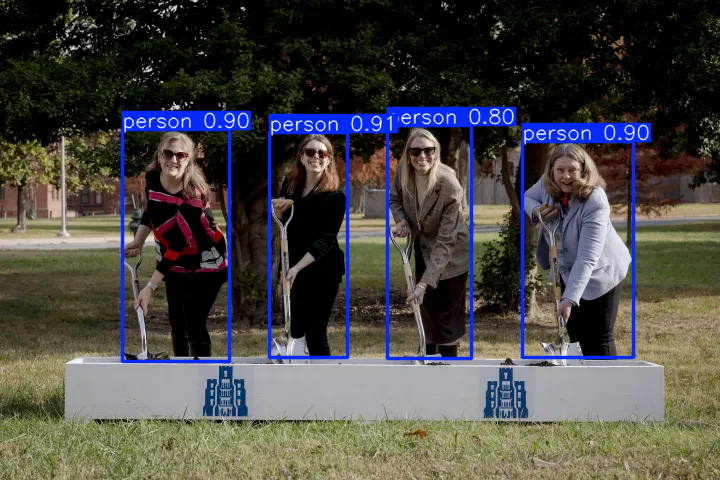

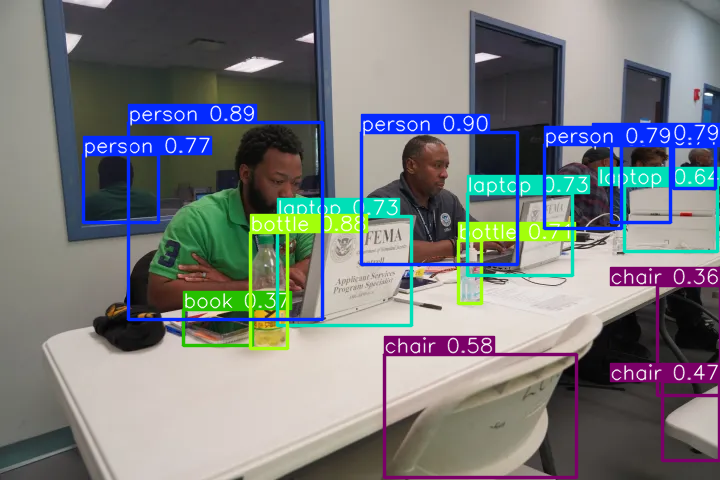

In [26]:
# Apply YOLO object detection to the first 20 images
results = model(images[:10])
results.show()

This part of the code consolidates all the object detection results from the YOLO model into a single pandas DataFrame. Each detected object includes information like its bounding box, confidence score, and object class. An image_index column is added to track which image each detection comes from.

In [7]:
import pandas as pd

bounding_boxes = results.pandas().xyxy

#  Concatenate all the bounding box DataFrames together, adding an index
#  to indicate which image they correspond to
all_results = pd.concat(
    [r.assign(image_index=i) for i, r in enumerate(bounding_boxes)] # SOLUTION
)
all_results

<ipython-input-7-d73271a8085a>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat(


xmin        ymin        xmax        ymax  confidence class  \
0   209.553375  215.458786  449.686920  384.032440    0.615104    63   
1     3.544245   37.233833  367.840424  644.413330    0.551479     0   
2     0.876679  523.085205  276.389801  719.182678    0.538364    56   
3   198.938232   32.546276  550.700684  359.416687    0.524203     0   
4   437.477142  343.940399  594.197998  394.793549    0.470753    73   
..         ...         ...         ...         ...         ...   ...   
6   174.779327  173.581924  329.350952  337.963989    0.546381     0   
7   182.494202  265.252899  336.555511  356.518890    0.458278    63   
8    66.507668  273.704315   85.505859  305.135193    0.406056    39   
9   654.721313  390.819794  719.708984  621.998840    0.308992    56   
10  291.856140  480.554108  377.433929  642.000000    0.267328    24   

        name  image_index  
0     laptop            0  
1     person            0  
2      chair            0  
3     person            0  
4       book            0  
..       ...          ...  
6     person           45  
7     laptop           45  
8     bottle           45  
9      chair           45  
10  backpack           45  

[505 rows x 8 columns]

Which image has the most people?

In [8]:
# Get the image with the most people
most_people_image = all_results[all_results['name'] == 'person'].groupby('image_index').size().idxmax()  # Image index with the most people

most_people_count = all_results[all_results['name'] == 'person'].groupby('image_index').size().max()  # Number of people in that image

print(f"The image with the most people is {most_people_image} with {most_people_count} people.")


The image with the most people is 31 with 17 people.


In [9]:
all_results[all_results['name'] == 'person'].groupby('image_index').size().sort_values()

image_index
19     1
20     1
12     1
16     1
33     1
25     2
0      2
37     2
38     3
27     3
4      3
44     3
26     4
39     4
41     4
35     4
28     4
45     4
8      4
2      4
5      4
10     4
43     6
9      6
17     6
15     7
7      7
14     7
13     8
29     8
18     9
42    10
32    10
6     10
3     11
23    11
34    11
40    12
24    12
11    13
36    13
21    14
31    17
dtype: int64

Which image has the most ties?

In [11]:
# Group by image_index to count ties and sort by count
tie_count = all_results[all_results['name'] == 'tie'].groupby('image_index').size()

# Find the image with the most ties
most_ties_image = tie_count.idxmax()  # Image index with the most ties
most_ties_count = tie_count.max()  # Number of ties in that image

print(f"The image with the most ties is {most_ties_image} with {most_ties_count} ties.")


The image with the most ties is 40 with 4 ties.


In [10]:
all_results[all_results['name'] == 'tie'].groupby('image_index').size().sort_values()

image_index
2     1
7     1
20    1
21    1
27    1
28    1
29    1
32    1
35    1
38    1
39    1
41    1
24    2
36    2
42    2
40    4
dtype: int64

### BLIP

BLIP is a library for image annotation: rather than trying to identify objects, it produces a short description of the image. The COCO dataset contains images of objects in different classes, and while it's usually used for classification and object detection, we can genenerate captions of these images too.

- Choose a food item category that exists in COCO and get image annotations for 10 images in that category.
- Do any of the images contain vegetables?

In [12]:
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

def generate_caption(img):
    inputs = processor(img, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [13]:
# Download the COCO dataset
# This will take a few minutes to run

import zipfile
import urllib.request
import requests
import os


urllib.request.urlretrieve("http://images.cocodataset.org/annotations/annotations_trainval2017.zip", "annotations_trainval2017.zip")

coco_dir = "./coco_annotations"

if not os.path.exists(coco_dir):
  os.mkdir(coco_dir)

with zipfile.ZipFile("annotations_trainval2017.zip", 'r') as zf:
    zf.extractall(coco_dir)

In [14]:
#  Use the COCO library to get the first 10 images in a category that
#  corresponds to a food item of your choice.

#  Look up the syntax for doing this and the image category names on the Web
from pycocotools.coco import COCO


coco = COCO(f'{coco_dir}/annotations/instances_train2017.json')
catIds = coco.getCatIds(
    catNms=['pizza'], # SOLUTION
)
imgIds = coco.getImgIds(catIds=catIds)
images = coco.loadImgs(imgIds)[:10]


loading annotations into memory...
Done (t=19.92s)
creating index...
index created!


In [15]:
import io

out_dir = 'coco_images'
if not os.path.exists(out_dir):
  os.mkdir(out_dir)


captions = []
image_objects = []
for i in images:
  # The coco url
  url = i['coco_url']

  filename = out_dir + '/' + os.path.basename(urllib.parse.urlparse(url).path)
  urllib.request.urlretrieve(
      url,
      filename
  )

  image = Image.open(filename)
  image_objects.append(image)
  captions.append(generate_caption(image))

In [17]:
captions

['a pizza on a table',
 'a man and a little girl eating pizza',
 'a woman sitting at a table with a plate of pizza',
 'a pizza with a slice missing from it',
 'a woman sitting at a table with a pizza',
 'a dough on a table with a rolling dough',
 'a pizza with vegetables and cheese on it',
 'a group of people standing around a table',
 'two children sitting on the floor eating pizza',
 'a pizza on a plate']

In [18]:
# BEGIN SOLUTION
# This is a very crude way of looking for text in text...

for i, c in enumerate(captions):
   if 'vegetable' in c:
    image_objects[i].show()
# END SOLUTION

In [20]:
contains_vegetables = False

for i, c in enumerate(captions):
    if 'vegetable' in c:
        contains_vegetables = True
        print(f"Image {i} caption mentions vegetables: {c}")
        image_objects[i].show()

if contains_vegetables:
    print("At least one image contains vegetables.")
else:
    print("No images contain vegetables based on captions.")


Image 6 caption mentions vegetables: a pizza with vegetables and cheese on it
At least one image contains vegetables.
